In [1]:
import tensorflow as tf
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import numpy as np


c:\Users\Kyle\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Kyle\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Kyle\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\Kyle\anaconda3\envs\deeplearning\lib\site-pack

Start-off talk

Training data: X=(60000, 28, 28), Y=(60000,)
Testing data: X=(10000, 28, 28), Y=(10000,)


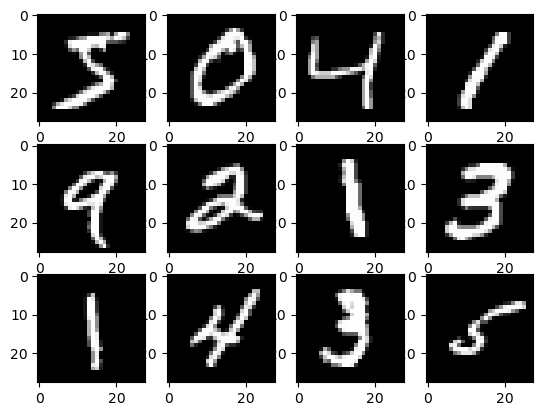

In [2]:
#loading dataset
train, test = tf.keras.datasets.mnist.load_data()
(trainX, trainY) = train
(testX, testY) = test

print(f'Training data: X=%s, Y=%s', trainX.shape, trainY.shape)
print(f'Testing data: X=%s, Y=%s', testX.shape, testY.shape)


# Displays 12 frames of the dataset.
for i in range(12):
    # Defines the subplot
    plt.subplot(3, 4, i + 1)  # 3 rows, 4 columns
    # Plots the frames in black and white.
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))

plt.show()

As we can see, the MNIST dataset is comprised entirely of handwritten numerical digits, 0 through 9. I'll be using a convolutional neural network (CNN) here to create a model that views a piece of writing and predicts what digit is shown.

Since they're all black and white, we can put them all into one color channel.

We can then put each sample into a single hot encoding. Each point will have a binary vector of 10, with 1 for the class value and 0 for all the other values. So, if the number is 3, it'll still print 3, but it'll be programed like this:

```{0, 0, 0, 1, 0, 0, 0, 0, 0, 0}```

After that, we'll need to turn the training and test input data from integers ranging [0, 255] to floats ranging [0, 1].

In [3]:
#putting it together into a handy function
def mnist_load():
  train, test = tf.keras.datasets.mnist.load_data()
  (trainX, trainY) = train
  (testX, testY) = test

  # reshaping the dataset
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # all hots to encode target values
  trainY = tf.keras.utils.to_categorical(trainY)
  testY = tf.keras.utils.to_categorical(testY)

  # scaling the pixels
  trainX = trainX.astype('float32') / 255.0
  testX = testX.astype('float32') / 255.0
  # ex. 173 -> .678431...

  return trainX, trainY, testX, testY

Now to start on the model. I'll use one (3, 3) convolutional layer and a changeable number of filters, ending with a max pooling layer. The learning rate and momentum will also be changeable. This allows for comparison on how differently set-up models will perform.

In [4]:
def mnist_model(filters=48, learning_rate=.009, momentum=0.9):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  #model compilation
  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Now we'll create the function for evaluating the model. We'll be using a k-fold here.

In [5]:
# Uses a k-fold to evaluate the model
# k-fold divides the testing data into n number of folds, each one taking turns
# being the testing data.
# Uses k-fold cross-validation to evaluate the model
def evaluate_model(trainX, trainY, filters=48, learning_rate=.009, momentum=0.9, n_folds=5, epochs=10, batch_size=32):
    scores = []
    histories = []
    
    # Create k folds, shuffling the data
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    
    # Iterate through each fold
    for train_ix, test_ix in kfold.split(trainX):
        # Construct the model
        model = mnist_model(filters, learning_rate, momentum)
        
        # Select rows for training and testing
        trainx, trainy = trainX[train_ix], trainY[train_ix]
        testx, testy = trainX[test_ix], trainY[test_ix]
        
        # Fit the model
        history = model.fit(trainx, trainy, epochs=epochs, batch_size=batch_size, validation_data=(testx, testy), verbose=0)
        
        # Evaluate the model
        _, acc = model.evaluate(testx, testy, verbose=0)
        print(f'Accuracy: {acc * 100:.2f}%')
        
        # Store scores and histories
        scores.append(acc)
        histories.append(history)
    
    return scores, histories


In [19]:
# Function to plot learning curves
def display_learning_curves(histories):
	for i in range(len(histories)):
		# Plot training loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')

		
		plt.legend(loc='upper right')
	
		# Plot training accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['acc'], color='blue', label='train')
		plt.plot(histories[i].history['val_acc'], color='orange', label='test')
		plt.legend(loc='lower right')

	plt.show()


In [20]:
# Function to display model performance summary
def display_performance_summary(scores):
	print(f'Accuracy: mean=%.3f std=%.3f, n=%d', np.mean(scores)*100, np.std(scores)*100, len(scores))
	
	plt.boxplot(scores)
	plt.show()

In [21]:
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = mnist_load()
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	display_learning_curves(histories)
	# summarize estimated performance
	display_performance_summary(scores)


Accuracy: 98.52%
Accuracy: 98.65%
Accuracy: 98.52%
Accuracy: 98.89%
Accuracy: 98.82%


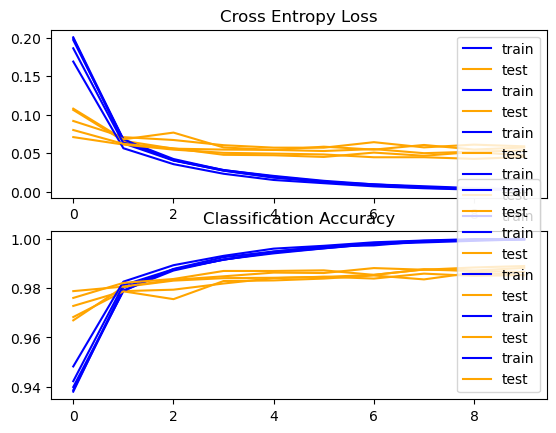

In [13]:
trainX, trainY, testX, testY = mnist_load()
# evaluate model
scores, histories = evaluate_model(trainX, trainY)
# learning curves
summarize_diagnostics(histories)


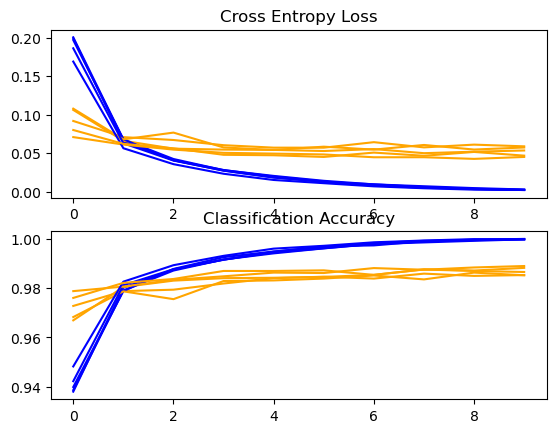

In [15]:
summarize_diagnostics(histories)

Accuracy: mean=%.3f std=%.3f, n=%d 98.68000149726868 0.15171358827501535 5


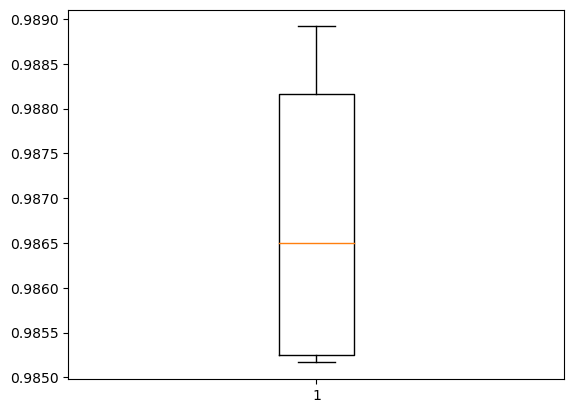

In [18]:
summarize_performance(scores)

Special thanks to Jason Brownlee for help.